In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# reading the dataset
dataset = pd.read_excel('./titanic3.xls')
#featurs left : pclass,survived,sex,age,fare,embarked
dataset = dataset.drop(['name', 'sibsp', 'parch', 'cabin', 'ticket','boat','body','home.dest'], axis=1)


#filling the empty cells with the mean of the column
dataset['embarked'].fillna(dataset['embarked'].mode()[0], inplace=True)
dataset['age'].fillna(dataset['age'].mean(), inplace=True)
dataset['fare'].fillna(dataset['fare'].mean(), inplace=True)

# encoding the categorical data
encode_col={'embarked':{'c':1,'C':1,'s':0,'S':0,'Q':2},
           'sex':{'female':0,'male':1}
           }
dataset=dataset.replace(encode_col)
dataset.fare=dataset.fare.astype(float)

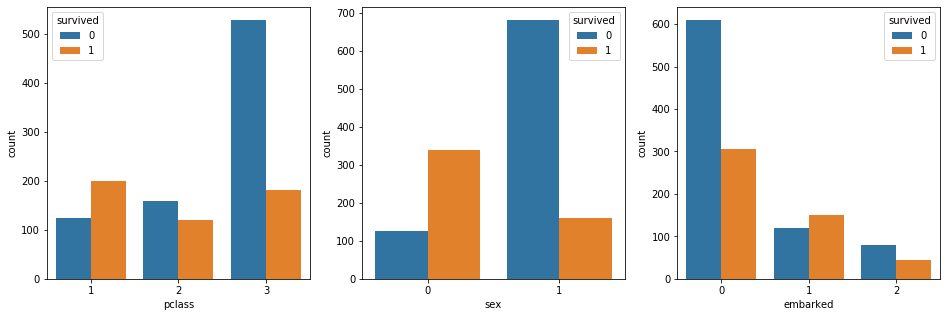

In [11]:
# some visualization 
import seaborn as sns
f,ax = plt.subplots(1,3,figsize=(16,5))
sns.countplot('pclass',hue='survived',data=dataset,ax=ax[0])
sns.countplot('sex',hue='survived',data=dataset,ax=ax[1])
sns.countplot('embarked',hue='survived',data=dataset,ax=ax[2])

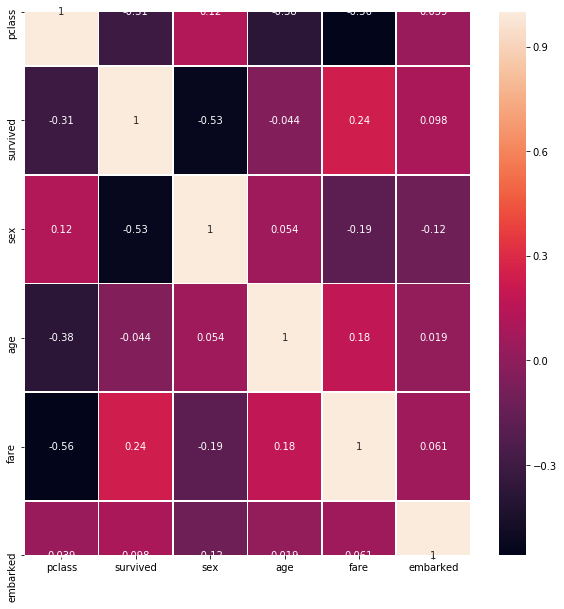

In [24]:

#correlation between variables

plt.figure(figsize=(10,10))
sns.heatmap(dataset.astype(float).corr(),linewidths=0.5, annot=True)
plt.show()

In [50]:
# normalization : min-max normalization

dataset['age']  = (dataset['age']-dataset['age'].max())/dataset['age'].max()-dataset['age'].min()
dataset['fare'] = (dataset['fare']-dataset['fare'].max())/dataset['fare'].max()-dataset['fare'].min()

In [51]:
# creating training set and testing set
dataset=dataset.astype(np.float)
train_data=dataset.iloc[0:1101,:]
test_data=dataset.iloc[1101:-1,:]

# the data after preproccining
dataset.head()

,pclass,survived,sex,age,fare,embarked
0,1.0,1.0,0.0,1.263257,0.014906,0.0
1,1.0,1.0,1.0,0.707117,-0.109898,0.0
2,1.0,0.0,0.0,0.728570,-0.109898,0.0
3,1.0,0.0,1.0,1.283060,-0.109898,0.0
4,1.0,0.0,0.0,1.184044,-0.109898,0.0


In [52]:

# creating Dataset
from torch.utils.data import DataLoader, Dataset
class Titanic3(Dataset) :
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        
        x = self.data.loc[index,['pclass','sex','age','fare','embarked']].values
        label = self.data.loc[index,'survived']
        
        
            
        return torch.FloatTensor(np.array(x)), torch.FloatTensor(np.array(label))

In [53]:
#tests xD
titanic3= Titanic3(train_data)
img, lab = titanic3.__getitem__(1)
print(img)
print(lab,"         ",train_data.loc[1,'survived'])

tensor([ 1.0000,  1.0000,  0.7071, -0.1099,  0.0000])
tensor(1.)           1.0


In [54]:
import torchvision
titanic3= Titanic3(train_data)
train_loader= DataLoader(titanic3, batch_size=32, shuffle=True)

In [55]:
import torch.nn.functional as F
class Model(torch.nn.Module) :
    def __init__(self):
        
        super(Model, self).__init__()
        self.fc1 = torch.nn.Linear(5,5)
        self.fc2 = torch.nn.Linear(5,3)
        self.fc3 = torch.nn.Linear(3,1)
        self.sigmoid=torch.nn.Sigmoid()
        self.relu=torch.nn.ReLU()
    def forward(self,x):
        x = self.fc1(x)
        x = F.dropout(x,0.2) #dropout to deal with overfiting
        x = self.relu(x)     
        x = self.fc2(x)
        x = F.dropout(x,0.5)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        
        return x

model=Model()

In [56]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [57]:
train_loss=0
epoch_accuracy=0
for epoch in range(1,250):
    train_loss=0
    epoch_accuracy = 0
    
    for x,y in train_loader :
        y_pred = model(x)
        loss = criterion(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
        accuracy = ((y_pred > 0.5).float() == y).float().mean()
        epoch_accuracy += accuracy
    if epoch % 10 == 0 :
        print("epoch :",epoch," loss : ",train_loss/len(train_loader.dataset), "     acc : ",epoch_accuracy/len(train_loader))

epoch : 10  loss :  0.021732980884496565      acc :  tensor(0.5775)
epoch : 20  loss :  0.021782088182277837      acc :  tensor(0.5763)
epoch : 30  loss :  0.021745818999547726      acc :  tensor(0.5789)
epoch : 40  loss :  0.021604698641965      acc :  tensor(0.5782)
epoch : 50  loss :  0.021634163854340874      acc :  tensor(0.5717)
epoch : 60  loss :  0.02155711610787138      acc :  tensor(0.5756)
epoch : 70  loss :  0.021559566340589392      acc :  tensor(0.5708)
epoch : 80  loss :  0.021513665079745673      acc :  tensor(0.5726)
epoch : 90  loss :  0.021488691112542563      acc :  tensor(0.5704)
epoch : 100  loss :  0.021358399202778162      acc :  tensor(0.5678)
epoch : 110  loss :  0.02107611187580604      acc :  tensor(0.5550)
epoch : 120  loss :  0.021204836795158975      acc :  tensor(0.5559)
epoch : 130  loss :  0.020664152992951882      acc :  tensor(0.5565)
epoch : 140  loss :  0.020338451883989934      acc :  tensor(0.5545)
epoch : 150  loss :  0.01992230817039483      ac

In [58]:
y_test=torch.FloatTensor(test_data.loc[:,'survived'].values)
x_test=torch.FloatTensor(test_data.drop(['survived'],axis=1).values)

In [61]:

acc=0
for i in range(len(x_test)) :
    yy=model(x_test[i]).item()
    if(yy>0.5) : yy=1
    else : yy=0
        
    
    if yy==y_test[i].data : acc=acc+1

acc=acc/len(x_test)
acc

0.855072463768116